In [6]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))


import sys
import os
import numpy as np
import h5py
import cPickle as pickle
import librosa
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

import func_model
sys.path.append("../../functions")
import func_data




from set_config import * 

# path
path_feat = path_feat
path_h5 = path_h5
path_exp = path_exp
path_model = path_model
path_result = path_result

# parameters for data
dim_feat = dim_feat
dim_embed = dim_embed
num_frame = num_frame

norm_type = norm_type
seed = seed
batch_size = batch_size

# parameters for train
num_epoch = num_epoch
num_patience = num_patience

294
(1, 626, 257)


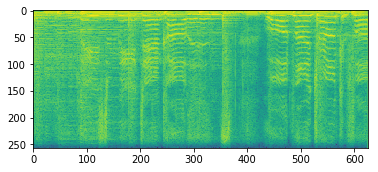

In [18]:
filename_data = os.path.join(path_h5, "test.h5")
filename_info = os.path.join(path_h5, "test.pickle")

filename_model = "../exp/003/model/model_best"
model = func_model.load_model(filename_model)


f = h5py.File(filename_data)
if norm_type == "glob":
    data_mean = np.array(f["mean_glob"])
    data_mean = data_mean[None, ...]
    data_std = np.array(f["std_glob"])
    data_std = data_std[None, ...]
elif norm_type == "freq":
    data_mean = np.array(f["mean_freq"])
    data_std = np.array(f["std_freq"])
else:
    data_mean = 0
    data_std = 1
f.close()

info = pickle.load(open(filename_info, "r"))
n_sample = len(info)
print n_sample
idx = 0


name, [idx_start, length] = info[idx]
filename_feat = os.path.join(path_feat, name+".h5")
f_feat = h5py.File(filename_feat)
mag = np.array( f_feat["mag"] )     # F * T
plt.imshow(mag)
pha = np.array( f_feat["pha"] )
mask = np.array( f_feat["mask"] )   # 2 * F * T
t = mask.T       # T * F * 2
f_feat.close()

x = (mag.T - data_mean) / data_std
x = x[None, ...]        # 1 * T * F
print x.shape

294
(1, 626, 257)


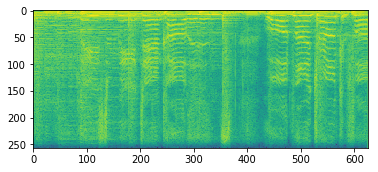

In [13]:
v = model.predict(x)    # 1 * T * F * D
T = v.shape[1]
F = v.shape[2]
D = v.shape[-1]

v = np.reshape(v, newshape=(-1, D))     # TF * D

kmean = KMeans(n_clusters=2, random_state=0).fit(v)
y = np.concatenate(((1 - kmean.labels_)[:, None], kmean.labels_[:, None]), axis=1)  # TF * 2
y = np.reshape(y, newshape=(T, F, -1))  # T * F * 2
y = y * np.sum(t, axis=-1)[..., None]   # T * F * 2
mask_pred = y.T     # 2 * F * T
s1 = np.sum(mask[0,...] * mask_pred[0,...]) + np.sum(mask[1,...] * mask_pred[1,...])
s2 = np.sum(mask[0,...] * mask_pred[1,...]) + np.sum(mask[1,...] * mask_pred[0,...])
if s1 < s2:
    mask_pred = np.flip(mask_pred, axis=0)
    

(1, 1251, 257)


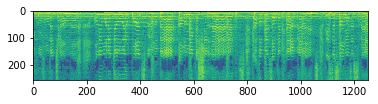

In [26]:
filename_audio = "tmp/002.wav"
wav, fs = librosa.core.load(filename_audio, sr=16000)
wav = wav[:160000]
mag, pha, mask = func_data.cal_spec_mask(wav, wav, wav)
plt.imshow(mag)

x = (mag.T - data_mean) / data_std
x = x[None, ...]        # 1 * T * F
print x.shape

In [27]:
v = model.predict(x)    # 1 * T * F * D
T = v.shape[1]
F = v.shape[2]
D = v.shape[-1]

v = np.reshape(v, newshape=(-1, D))     # TF * D

kmean = KMeans(n_clusters=2, random_state=0).fit(v)
y = np.concatenate(((1 - kmean.labels_)[:, None], kmean.labels_[:, None]), axis=1)  # TF * 2
y = np.reshape(y, newshape=(T, F, -1))  # T * F * 2
mask_pred = y.T     # 2 * F * T

wav_1 = func_data.restore_wav(mag, pha, mask_pred[0, ...])
wav_2 = func_data.restore_wav(mag, pha, mask_pred[1, ...])
librosa.output.write_wav("tmp/002_1.wav", wav_1, 16000)
librosa.output.write_wav("tmp/002_2.wav", wav_2, 16000)


Text(0.5,1,'predicted')

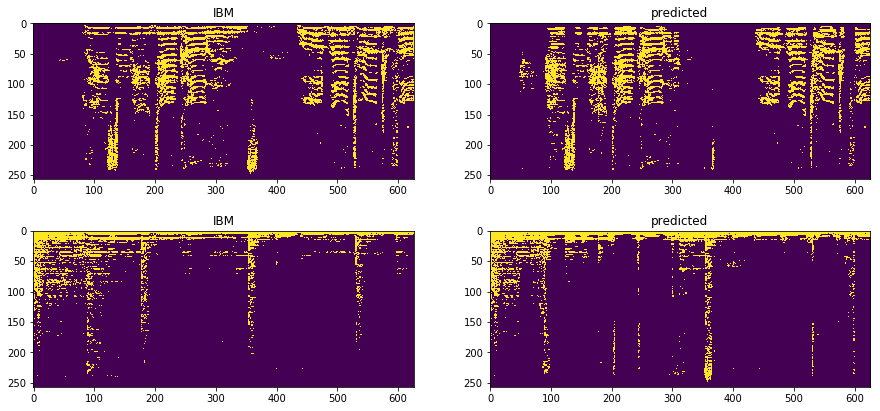

In [3]:


fig, ax = plt.subplots(2, 2, figsize=(15,7))
ax[0,0].imshow(mask[0, ...])
ax[0,0].set_title("IBM")
ax[0,1].imshow(mask_pred[0, ...])
ax[0,1].set_title("predicted")
ax[1,0].imshow(mask[1, ...])
ax[1,0].set_title("IBM")
ax[1,1].imshow(mask_pred[1, ...])
ax[1,1].set_title("predicted")


In [2]:
import musdb
import museval

In [3]:
mus = musdb.DB()

RuntimeError: Variable `MUSDB_PATH` has not been set.